# Frequency response of a Pound-Drever-Hall error signal
By Josiah Sinclair

Imagine we've got some laser you want to frequency stabilize to a reference cavity, and you know that your laser is nearly a perfect oscillator with frequency $f_0$, but with a phase that oscillates with amplitude $\beta$ at frequency $f_N$. How successfully should we be able to actively compensate that phase error? 

In [2]:
# First, let me import some useful Python packes
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import scipy as sp
from scipy import signal as sig
from scipy.optimize import curve_fit

In [3]:
# Functions I will use. 
def FrequencyFilter(t,ydata, cutoff_frequency):
    dt = abs(t[2]-t[1])
    df = 1.0/(abs(max(t)-min(t)))
    f_max = 1.0/dt
    f= np.arange(-f_max/2-df/2.0,f_max/2,df)
    FT = np.fft.fftshift(np.fft.fft(ydata)) # Take a Fourier transform.
    Filter_Function = np.exp(-(2*np.pi*f)**2/(2*2*np.pi*cutoff_frequency)**2) # Filter function (regular definition of sigma as rms but multiplied by two because i'm filtering the amplitude not the power spectrum.
    Filtered_FT = FT*Filter_Function 
    Filtered_E_T = np.real(np.fft.ifft(np.fft.ifftshift(Filtered_FT)))
    return((Filtered_E_T)) # Returns the frequency filtered field values

def PowerSpectrum(t,ydata):
    dt = abs(t[2]-t[1]) # Define my smallest time step.
    
    df = 1.0/(abs(max(t)-min(t))) # Define my smallest frequency step.
    f_max = 1.0/dt # Define the frequency range. 
    f = np.arange(-f_max/2-df/2,f_max/2,df)
    
    FT = np.fft.fftshift(np.fft.fft(ydata)) # Take a Fast Fourier transform.
    PWRspectrum = np.real(np.conj(FT)*FT)/df # Find the power density spectrum (power per df)
    return(f, PWRspectrum) # This function returns the frequency values as well as the frequency spectrum.
                     
def CavityResponse(f, f_0, gamma):
           return(4*1j*(f-f_0)/gamma/2/(1+2*1j*(f-f_0)/gamma))
    
def Cavity(t,E,cavity_resonance, gamma):
    dt = abs(t[2]-t[1])
    df = 1.0/(abs(max(t)-min(t)))
    f_max = 1.0/dt
    f= np.arange(-f_max/2-df/2.0,f_max/2,df)
    FT = np.fft.fftshift(np.fft.fft(E)) # Take a Fourier transform.
    Reflected_FT = FT*CavityResponse(f, cavity_resonance, gamma)
    Reflected_E_T = np.fft.ifft(np.fft.ifftshift(Reflected_FT))
    return((Reflected_E_T)) # Returns the frequency filtered field values

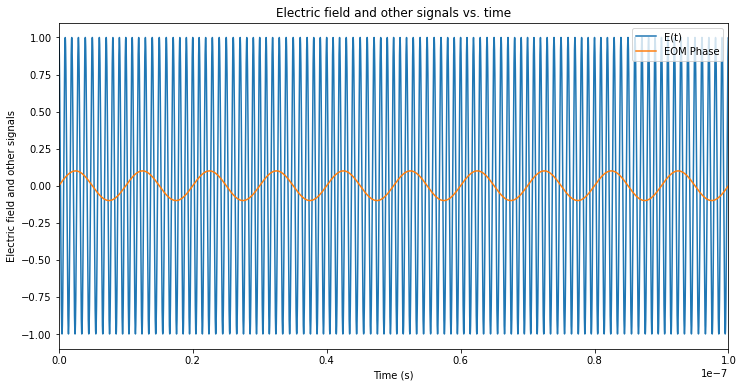

In [6]:
# First, let me define an electric field oscillating at 1 GHz.
# Next, I'll use an EOM to add phase modulation at 100 MHz.
# Eventually, I'll add the phase error, but not yet. 

dt = 1e-11 #Smallest time step.
t_max = 1e-6 #This limits the smallest frequencies I can resolve
t = np.arange(0,t_max,dt) #Time array
f_0 = 1e9 # This laser is more of a maser
f_N = 5e6 #Frequency of my phase noise
f_EOM = 100e6 # EOM frequency
EOMPhase = .5*np.sin(2*np.pi*f_EOM*t) #This is my EOM drive phase modulation
E = np.exp(1j*2*np.pi*f_0*t +1j*EOMPhase) #This is my electric field

#Let's plot the electric field and other signals in time
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(t,np.real(E), '-', label = "E(t)")
ax.plot(t,EOMPhase/5, label = "EOM Phase")
ax.set_title("Electric field and other signals vs. time")
ax.set_ylabel("Electric field and other signals")
ax.set_xlabel("Time (s)")
ax.set_xlim(0,100/f_0)
ax.legend(loc = "upper right")
plt.show()

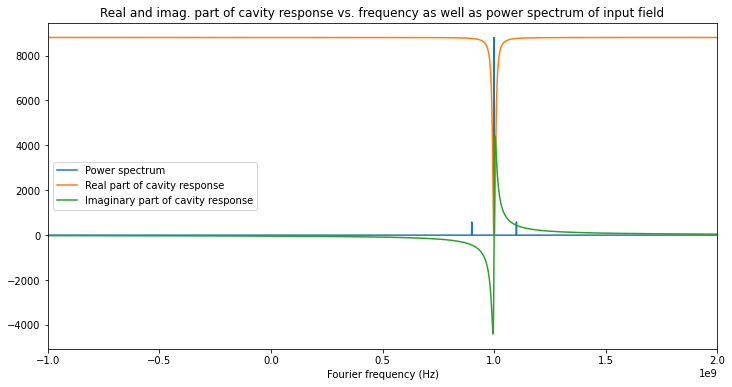

In [8]:
# Let's plot the power spectrum of electric field as well as the real and imaginary part of the cavity transmission
f, Spectrum = PowerSpectrum(t,E) # Use my handy-dandy power spectrum function to calculate the power spectrum
plt.figure(figsize = (12,6))
plt.plot(f,Spectrum, label = "Power spectrum")

gamma = 10e6
T = CavityResponse(f,f_0, gamma) #Use my handy-dandy response function to calculate the response vs. frequency. 
plt.plot(f,max(Spectrum)*np.real(T)*np.real(T), label = "Real part of cavity response")
plt.plot(f,max(Spectrum)*np.imag(T), label = "Imaginary part of cavity response")
plt.xlim(-1*f_0, 2*f_0)
plt.title("Real and imag. part of cavity response vs. frequency as well as power spectrum of input field")
plt.xlabel("Fourier frequency (Hz)")
plt.legend(loc = "center left")
plt.show()

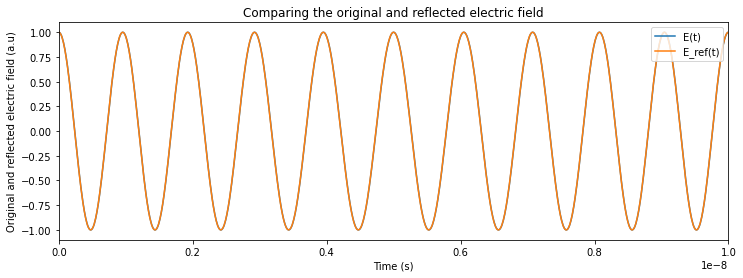

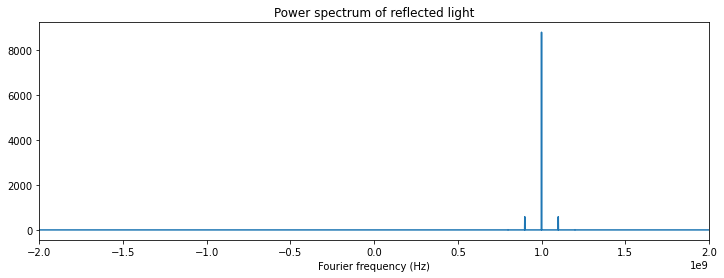

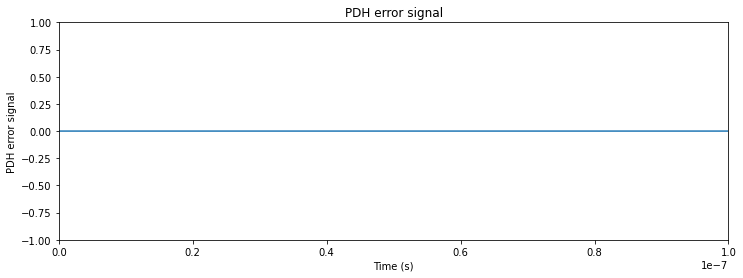

In [14]:
# Ok, let's go ahead and perform a few sanity checks. 
# First, let's calculate the reflected field with the cavity off resonance (so the cavity should have no effect).
# To do this, I can use my handy-dandy functino that takes as an input the EOM phase modulated electric field 
# and cavity parameters and returns the reflected field. 
E_ref = Cavity(t,E,f_0*0.5, gamma) 


# Let's plot E_ref and compare it to E.
# Because the cavity is off-resonance, these should be the same.
plt.figure(figsize = (12,4))
plt.plot(t, np.real(E), label = "E(t)")
plt.plot(t, np.real(E_ref), label = "E_ref(t)")
plt.xlim(0,10/f_0)
plt.legend(loc = "upper right")
plt.title("Comparing the original and reflected electric field")
plt.xlabel("Time (s)")
plt.ylabel("Original and reflected electric field (a.u)")

# Great, now let's plot the power spectrum of the reflected field.
# Because the cavity is off-resonance it should look the same as the power spectrum of the input field,
# which was plotted in the previous cell.
f, Spectrum_Reflected = PowerSpectrum(t,E_ref)
plt.figure(figsize = (12,4))
plt.plot(f,Spectrum_Reflected)
plt.xlim(-2*f_0,2*f_0)
plt.title("Power spectrum of reflected light")
plt.xlabel("Fourier frequency (Hz)")

# Ok great.
# Now, assuming that we have properly calculated the reflected field, how do we produce an error signal? 
ErrorSignalPreMixer = np.real(E_ref*np.conjugate(E_ref)) # First, detect the reflected field with a fast detector. 
ErrorSignalPostMixer = ErrorSignalPreMixer*np.sin(2*np.pi*f_EOM*t) # Next, mix the detected signal with an LO.
ErrorSignalLowpass = FrequencyFilter(t,ErrorSignalPostMixer, f_EOM/10) # Finally, lowpass filter at f_EOM/10. 
# To lowpass filter, I will use my hand-dandy frequency filter function. 

# Great, let's plot the error signal. It should be zero!
plt.figure(figsize = (12,4))
plt.plot(t, ErrorSignalLowpass)
plt.xlim(0,100/f_0)
plt.ylim(-1,1)
plt.title("PDH error signal")
plt.xlabel("Time (s)")
plt.ylabel("PDH error signal")
plt.show()

plt.show()

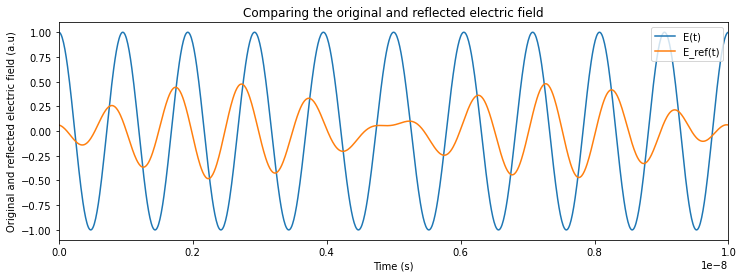

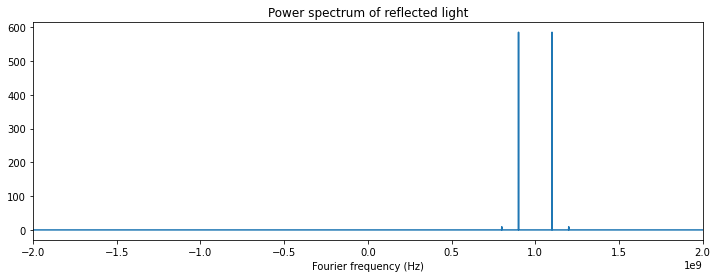

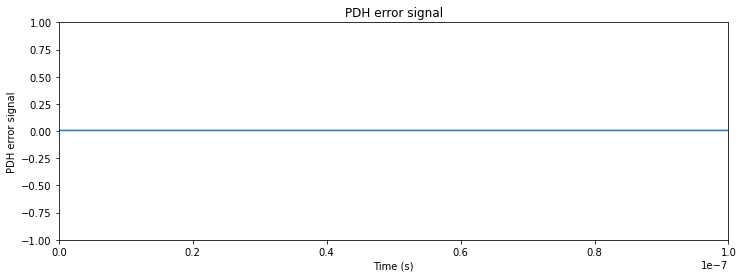

In [15]:
# Ok, let's do it all again, but this time let's put the cavity on resonance.
E_ref = Cavity(t,E,f_0, gamma)


# Let's plot E_ref and compare it to E. 
# Now that the cavity is on resonance, these are not expected to be the same. 
plt.figure(figsize = (12,4))
plt.plot(t, np.real(E), label = "E(t)")
plt.plot(t, np.real(E_ref), label = "E_ref(t)")
plt.xlim(0,10/f_0)
plt.legend(loc = "upper right")
plt.title("Comparing the original and reflected electric field")
plt.xlabel("Time (s)")
plt.ylabel("Original and reflected electric field (a.u)")

# What is the power spectrum of my reflected beam? 
# Now that the cavity is on resonance I shouldn't expect it to look the same as the spectrum of the input field. 
f, Spectrum_Reflected = PowerSpectrum(t,E_ref)
plt.figure(figsize = (12,4))
plt.plot(f,Spectrum_Reflected)
plt.xlim(-2*f_0,2*f_0)
plt.title("Power spectrum of reflected light")
plt.xlabel("Fourier frequency (Hz)")


# Ok great, now how is an error signal usually produced? 
ErrorSignalPreMixer = np.real(E_ref*np.conjugate(E_ref)) # First, detect the reflected field with a fast detector. 
ErrorSignalPostMixer = ErrorSignalPreMixer*np.sin(2*np.pi*f_EOM*t) # Next, mix the detected signal with an LO.
ErrorSignalLowpass = FrequencyFilter(t,ErrorSignalPostMixer, f_EOM/10) # Finally, lowpass filter at f_EOM/10. 

# Great, let's plot the error signal. Because the cavity is right on resonance it should be zero!
plt.figure(figsize = (12,4))
plt.plot(t, ErrorSignalLowpass)
plt.xlim(0,100/f_0)
plt.ylim(-1,1)
plt.title("PDH error signal")
plt.xlabel("Time (s)")
plt.ylabel("PDH error signal")
plt.show()

plt.show()

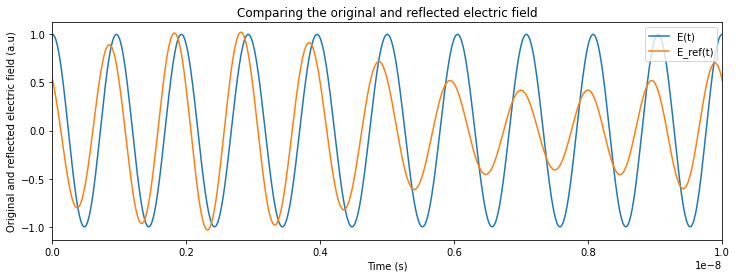

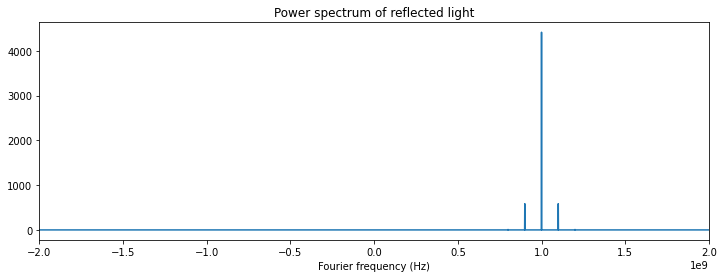

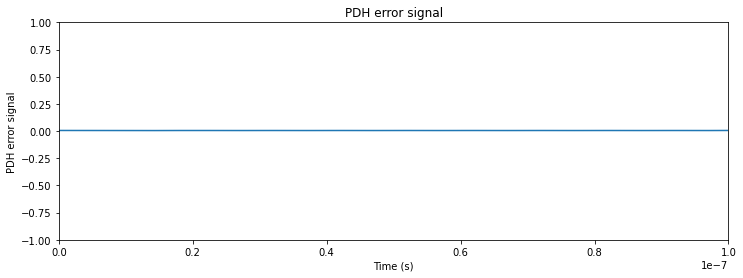

In [16]:
# Ok, let's do it again with the cavity one half cavity linewidth detuned
E_ref = Cavity(t,E,f_0-gamma/2, gamma)


# Let's plot E_ref and compare it to E. 
# Now that the cavity is slightly off-resonance, these are not expected to be the same. 
plt.figure(figsize = (12,4))
plt.plot(t, np.real(E), label = "E(t)")
plt.plot(t, np.real(E_ref), label = "E_ref(t)")
plt.xlim(0,10/f_0)
plt.legend(loc = "upper right")
plt.title("Comparing the original and reflected electric field")
plt.xlabel("Time (s)")
plt.ylabel("Original and reflected electric field (a.u)")


# What is the power spectrum of my reflected beam? 
f, Spectrum_Reflected = PowerSpectrum(t,E_ref)
plt.figure(figsize = (12,4))
plt.plot(f,Spectrum_Reflected)
plt.title("Power spectrum of reflected light")
plt.xlabel("Fourier frequency (Hz)")
plt.xlim(-2*f_0,2*f_0)


# Ok great, now how is an error signal usually produced? 
ErrorSignalPreMixer = np.real(E_ref*np.conjugate(E_ref))
ErrorSignalPostMixer = ErrorSignalPreMixer*np.sin(2*np.pi*f_EOM*t)
ErrorSignalLowpass = FrequencyFilter(t,ErrorSignalPostMixer, f_EOM/10) 

plt.figure(figsize = (12,4))
plt.plot(t, ErrorSignalLowpass)
plt.title("PDH error signal")
plt.xlabel("Time (s)")
plt.ylabel("PDH error signal")
plt.xlim(0,100/f_0)
plt.ylim(-1,1)
plt.show()

plt.show()

In [12]:
# Alright, let's put everything together and define a new function. 
# This new function takes the cavity detuning and calculates the reflected field. 
# From the reflected field, it calculates the PDH error signal. 
# As an additional feature, I'll now add phase errors/noise in the form of phase modulation at f_N.
def PDH(f_N, cavity_detuning, noiseAmp):
    PhaseNoise1 = (noiseAmp/f_N)*np.sin(2*np.pi*f_N*t) # This is my phase noise.
    EOMPhase1 = .5*np.sin(2*np.pi*f_EOM*t) # This is my EOM phase modulation.
    E1 = np.exp(1j*2*np.pi*f_0*t + 1j*PhaseNoise1+1j*EOMPhase1) # This is my input electric field.
    E_ref1 = Cavity(t,E1,f_0-cavity_detuning, gamma) # This is my reflected field.
    ErrorSignalPreMixer1 = np.real(E_ref1*np.conjugate(E_ref1)) # This is what my reflection detector measures.
    ErrorSignalPostMixer1 = ErrorSignalPreMixer1*np.sin(2*np.pi*f_EOM*t) # Mix with LO.
    ErrorSignalLowpass1 = FrequencyFilter(t,ErrorSignalPostMixer1, f_EOM/10) # Lowpass filter at F_EOM/10.
    return(ErrorSignalLowpass1) 

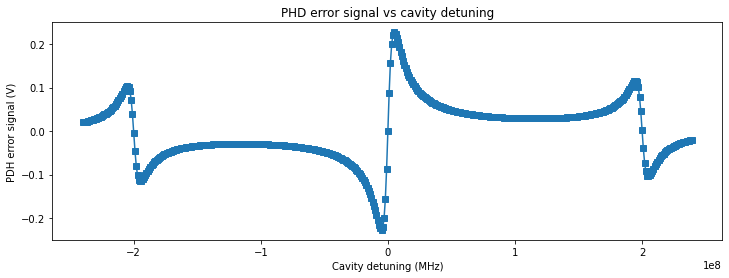

In [17]:
# Great, first, let's set the amplitude of the phase errors to zero and just vary the detuning. 
dt = 1e-11
t_max = 1e-6
t = np.arange(0,t_max,dt) #Timing resolution.
f_0 = 1e9 # This laser is more of a maser.
f_N = 5e6 #Frequency of my phase noise.
f_EOM = 200e6 # Frequency of my EOM.
gamma = 10e6 # Cavity linewidth.
cav_det = np.arange(-24*gamma, 24*gamma,0.1*gamma) # Cavity detunings
PDH_error = 0*cav_det
for i in range(len(cav_det)):
    PDH_error[i] = np.mean(PDH(f_N, cav_det[i], 0))

        
plt.figure(figsize = (12,4))
plt.plot(cav_det, PDH_error, '-s')
plt.title("PHD error signal vs cavity detuning")
plt.xlabel("Cavity detuning (MHz)")
plt.ylabel("PDH error signal (V)")
plt.show()

Cool, so you can see the famous PDH error signal shape, which is the shape your error signal will take if you slowly scan your laser's frequency across resonance. 

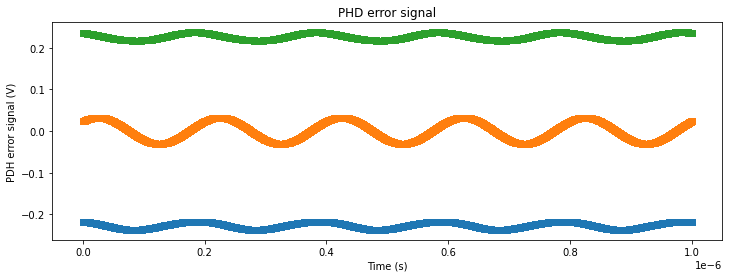

In [26]:
# Alright, finally, let's sit at a few different detunings and see what happens if we have non-zero phase errors.  
plt.figure(figsize = (12,4))
plt.plot(t, PDH(f_N, -.5*gamma, 0.1*f_N), '-s')
plt.plot(t, PDH(f_N, 0, 0.1*f_N), '-s')
plt.plot(t, PDH(f_N, .5*gamma, 0.1*f_N), '-s')
plt.title("PHD error signal")
plt.xlabel("Time (s)")
plt.ylabel("PDH error signal (V)")
plt.show()

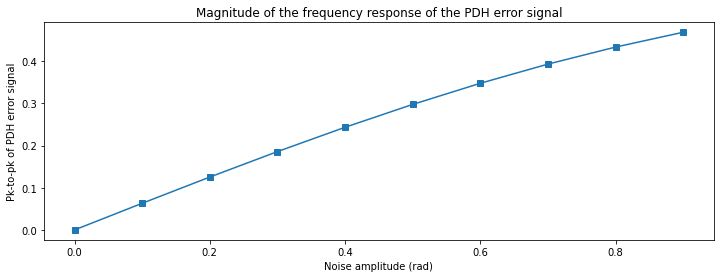

In [32]:
# What if we sit on resonance and just vary the amplitude of the phase errors? 
# How does the amplitude of the oscillations in the PDH error signal change? 
NoiseAmp = np.arange(0, 1, .1)*f_N
PDH_error = 0*NoiseAmp
for i in range(len(NoiseAmp)):
    PDH_error[i] = np.ptp(PDH(f_N, 0, NoiseAmp[i]))

plt.figure(figsize = (12,4))
plt.plot(NoiseAmp/f_N, PDH_error, '-s')


plt.title("Magnitude of the frequency response of the PDH error signal")
plt.xlabel("Noise amplitude (rad)")
plt.ylabel("Pk-to-pk of PDH error signal")
plt.show()  
    

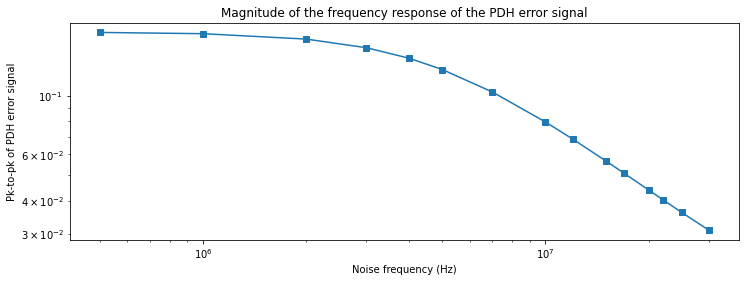

In [33]:
# What if we sit on resonance and just vary the frequency of the phase errors? 
# How does the amplitude of PDH error signal oscillations depend on the frequency of the phase errors? 
dt = 1e-11
t_max = 10e-6
t = np.arange(0,t_max,dt) #Timing resolution
f_0 = 1e9 # This laser is more of a maser
f_EOM = 200e6
gamma = 10e6
FreqNoiseAmp = 1e6
# f_N = np.array([0.01e6, 0.02, 0.03, 0.04, 0.05e6, 0.1e6, 0.2e6, 0.5e6, 1e6, 2e6, 3e6, 4e6, 5e6, 7e6, 10e6, 12e6, 15e6, 17e6, 20e6, 22e6, 25e6, 30e6])
f_N = np.array([0.5e6, 1e6, 2e6, 3e6, 4e6, 5e6, 7e6, 10e6, 12e6, 15e6, 17e6, 20e6, 22e6, 25e6, 30e6])
cav_det = 0
PDH_error = 0*f_N
for i in range(len(f_N)):
    PDH_error[i] = np.ptp(PDH(f_N[i], cav_det, FreqNoiseAmp))

        
plt.figure(figsize = (12,4))
plt.plot(f_N, PDH_error, '-s')
plt.yscale('log')
plt.xscale('log')

plt.title("Magnitude of the frequency response of the PDH error signal")
plt.xlabel("Noise frequency (Hz)")
plt.ylabel("Pk-to-pk of PDH error signal")
plt.show()

What you can see happening here is that as the frequency of the phase noise increases, the pk-pk of the PDH error signal is constant up to some point, above which it decreases. The knee can be seen to occur at the linewidth of the cavity. 

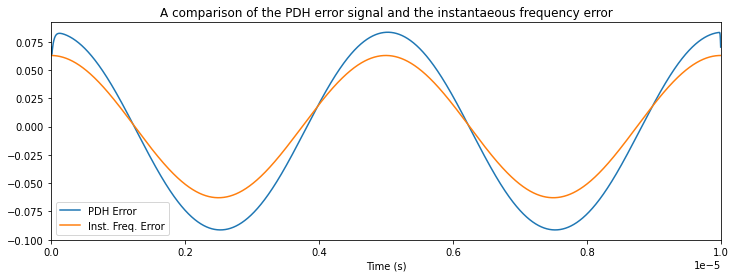

In [45]:
# Let's just compare the phase and amplitude of the PDH error signal to the instantaneous frequency error 
# induced by the phase noise when f_N3 = 200 kHz.
f_N3 = 0.2e6
Error3 = PDH(f_N3, 0, FreqNoiseAmp)
inst_freq = np.gradient(FreqNoiseAmp*np.sin(2*np.pi*f_N3*t))/200 # 1/500 ~ J0(B)*J1(B) etc
plt.figure(figsize = (12,4))
plt.plot(t,Error3, label = "PDH Error")
plt.plot(t,inst_freq, label = "Inst. Freq. Error" )
plt.legend()
plt.title("A comparison of the PDH error signal and the instantaeous frequency error")
plt.xlabel("Time (s)")
plt.xlim(0, 2/f_N3)
plt.show()

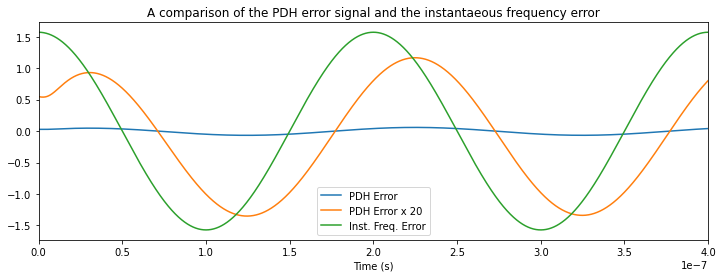

In [49]:
# Let's just compare the phase and amplitude of the PDH error signal to the instantaneous frequency error 
# induced by the phase noise when f_N3 = 5 MHz. 
f_N3 = 5e6
Error3 = PDH(f_N3, 0, FreqNoiseAmp)
inst_freq = np.gradient(FreqNoiseAmp*np.sin(2*np.pi*f_N3*t))/200 # 1/500 ~ J0(B)*J1(B) etc
plt.figure(figsize = (12,4))
plt.plot(t,Error3, label = "PDH Error")
plt.plot(t,Error3*20, label = "PDH Error x 20")
plt.plot(t,inst_freq, label = "Inst. Freq. Error" )
plt.legend()
plt.title("A comparison of the PDH error signal and the instantaeous frequency error")
plt.xlabel("Time (s)")
plt.xlim(0, 2/f_N3)
plt.show()

What is going on here? What is happening is that that the PDH error signal is proportional to the instantaneous frequency error produced by phase modulation that is slow compared to the cavity ringdown time. When the phase is modulated fast compared to the cavity ringdown time, the PDH error signal becomes simply proportional to the phase error, meaning that it the error signal is suppressed by the ratio of $f_N/\gamma$ (the lowpass effect we saw in a previous cell) and that it gets 45 degrees out of phase with the instantaneous frequency error (as we see in the previous cell). 